In [2]:
import torch
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from matplotlib import rc, colors
import numpy as np
import xarray as xr
import metpy.plots.ctables

rc("font", **{"family": "Times"})
rc("text", usetex=True)
plt.rcParams['figure.dpi']= 300

samples = torch.load("samples.pt", map_location=torch.device('cpu'))

Indices with max individual cells: [812, 218, 486, 547, 337, 60, 925, 395, 704, 583, 523, 472, 201, 211, 234, 474, 810, 858, 830, 311]
Indices with max mean cells: [600, 1005, 152, 497, 674, 211, 616, 881, 137, 237, 987, 1000, 651, 164, 131, 329, 214, 113, 245, 206]


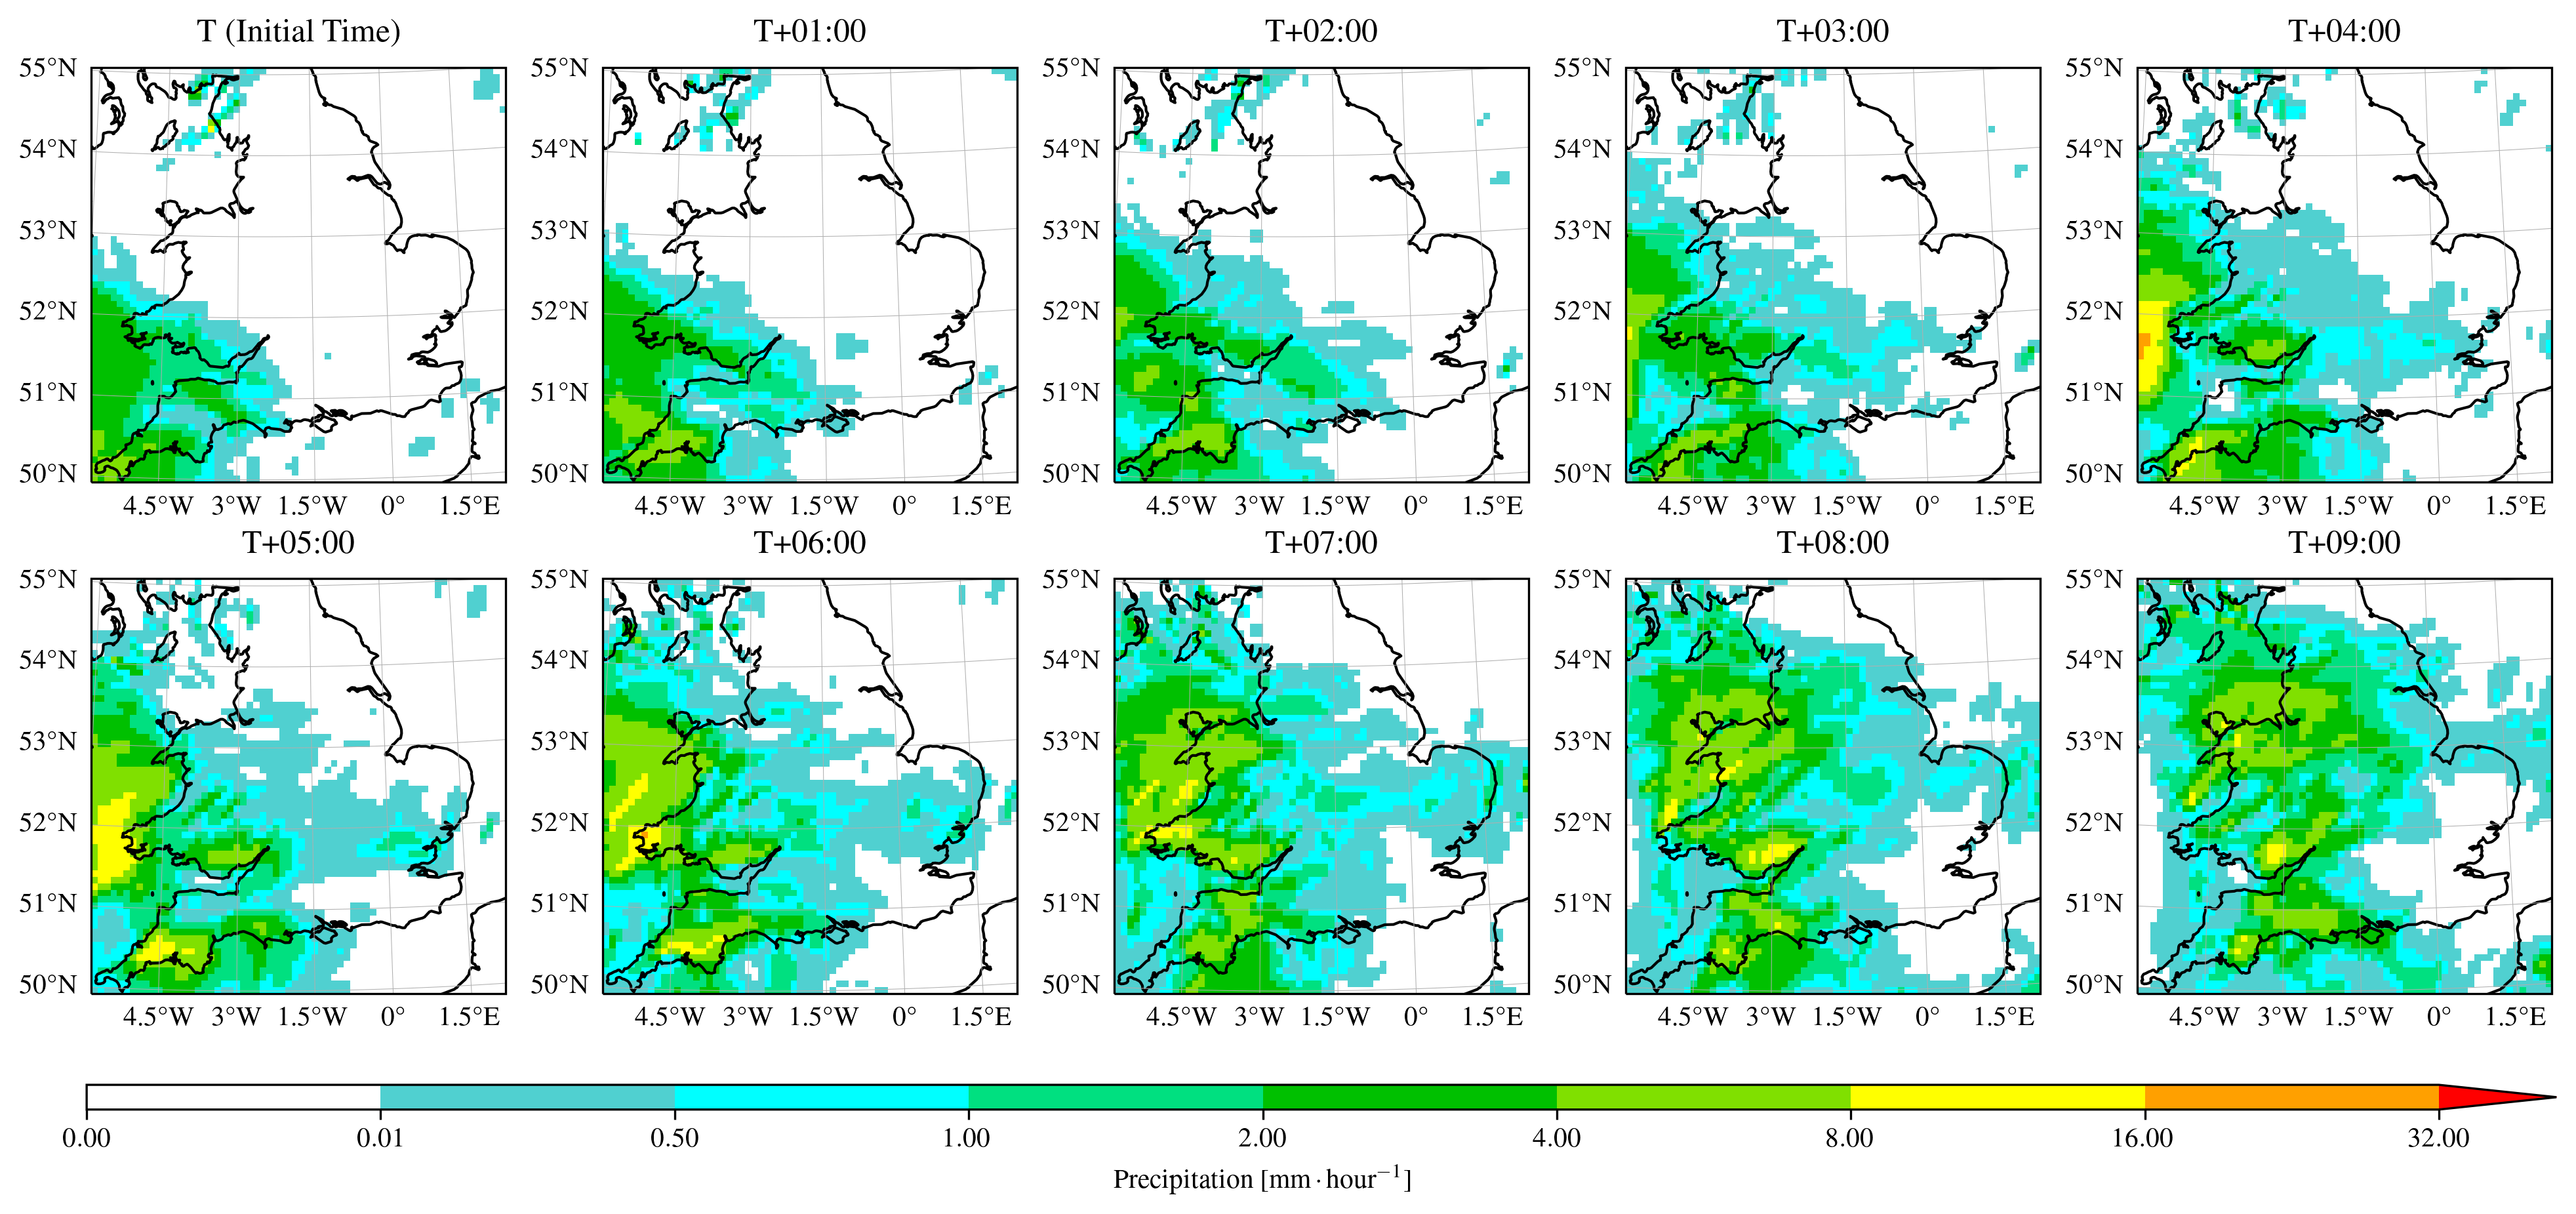

In [9]:
def plot_sample(sample):
    precip_clevs = [0, 0.01, 0.5, 1, 2, 4, 8, 16, 32]
    precip_cmap = colors.ListedColormap(
    metpy.plots.ctables.colortables["precipitation"][: len(precip_clevs) - 1],
    "precipitation",
    )
    precip_cmap.set_over(metpy.plots.ctables.colortables["precipitation"][len(precip_clevs) - 1])
    precip_norm = colors.BoundaryNorm(precip_clevs, precip_cmap.N)

    cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)

    fig, axes = plt.subplots(
        nrows=2,
        ncols=5,
        figsize=(13, 6),
        layout = "constrained",
        subplot_kw={'projection': cp_model_rotated_pole},
    )

    for i, ax in enumerate(axes.flat):
        im = sample.isel(time=i).plot.pcolormesh(
            ax=ax, 
            x = 'longitude', 
            y = 'latitude',
            cmap = precip_cmap,
            norm = precip_norm,
            extend = 'max',
            transform=ccrs.PlateCarree(),
            add_colorbar = False,
        )
        ax.gridlines(linewidth = 0.25, draw_labels={"bottom": "x", "left": "y"}, x_inline=False, y_inline=False)
        ax.coastlines(resolution='10m')
        if i == 0:
            ax.set_title(f"T (Initial Time)")
        else:
            ax.set_title(f"T+0{i}:00")

    fig.colorbar(
        im, 
        ax = axes, 
        orientation="horizontal", 
        aspect=100, 
        # shrink = 1,
        label='Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]',
    )

    plt.show()

sample = samples[1000][0]

print("Indices with max individual cells:", torch.flip(torch.sort(torch.amax(samples.reshape(-1, 10 * 64 * 64), dim=1)).indices, dims=(0,)).tolist()[:20])
print("Indices with max mean cells:", torch.flip(torch.sort(torch.mean(samples.reshape(-1, 10 * 64 * 64), axis=1)).indices, dims=(0,)).tolist()[:20])

latitudes = xr.DataArray(np.load('latitude.npy'), dims = ('y', 'x'))
longitudes = xr.DataArray(np.load('longitude.npy'), dims = ('y', 'x'))
da = xr.DataArray(sample, dims=('time', 'y', 'x'), coords={'latitude': latitudes, 'longitude': longitudes})
plot_sample(da)